# Technical Report

Executive Summary

The objective of this project is to work with an Atlanta area hospital to develop a methodology for predicting demand for emergency department (ED) services by characterizing ED arrivals.  Having the ability to forecast accurately predict patient volumes will lead to the following benefits for hospitals:  

•	Reduce Employee costs (e.g. Drs, Nurses, PAs, Admin, etc.)
•	Reduce Drug Inventory costs (e.g. Stocking costs, Cost-of-Carry, etc)
•	Reduce other operating costs (e.g. Utilities)


Introduction

Shifts in the supply and demand for emergency department (ED) resources make the efficient allocation of ED resources increasingly important. Forecasting is a vital activity that guides decision-making in many areas of economic, industrial, and scientific planning, but has gained little traction in the health care industry. There have been few projects that explore the use of forecasting methods to predict patient volumes in the ED.


Methods

Daily patient arrivals were collected for the period January 1, 2010, through December 31, 2014.  The attached analysis was based on 365 days of the 2014 calendar year.  Autocorrelation & Partial Autocorrelation was used to determine the correlation between the time series and a lagged version of itself.

Because the time series did not posses stationarity, I performed a decomposition analysis to separate the seasonal, operational, and cyclical trends from the residual portion of the time series.  The Augmented Dickey Fuller (ADF) was used to confirm stationarity.  I evaluated the output of an autoregressive integrated moving average (ARIMA) model and compared it to the outputs from two autoregressive moving average (ARMA) models.  The Akaike Information Criterion (AIC) helped me to determine the ARIMA model was the better to use on the time series and to predict daily patient volumes for the local Atlanta Hospital.

Forecasts were made for horizons ranging from 1 to 180 days in advance. The forecast accuracy achieved by the various forecasting methods was compared to actual patient visits to the Emergency Department.


Results

All time series methods considered in this project provided improved out-of- sample model “goodness of fit”.  However, it is the opinion of the this author that ARIMA Models in conjunction with other models (e.g., neural networks) may provide better forecast accuracy in predicting daily ED volumes. 


Conclusion

This project confirms the widely held belief that daily demand for ED services is characterized by seasonal, maybe weekly patterns. The author compared several time series forecasting methods to determine ARIMA was the better prediction method for daily ED patients.  It is also the opinion of the author that ARIMA in conjunction with another prediction method (e.g., neural networks) could produce a more improved result. 


Recommendation

Use ARIMA in conjunction with another prediction model.


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import _arma_predict_out_of_sample
from sklearn.metrics import r2_score

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Importing csv file
df = pd.read_csv('ED Arrival Data (Daily No Headings) 1 yr.csv') 

# Data Munging & EDA

In [3]:
# Reviewing first few lines of csv file
df.head()  

,Shift Start Date,Day of Week,ED Hospital 1,ED Hospital 2
0,01/01/2014,Wed,169,233
1,01/02/2014,Thu,140,202
2,01/03/2014,Fri,148,198
3,01/04/2014,Sat,145,245
4,01/05/2014,Sun,125,232


In [4]:
#Reviewing the type of Data in each column
df.dtypes  

Shift Start Date    object
Day of Week         object
ED Hospital 1        int64
ED Hospital 2        int64
dtype: object

In [5]:
# Renaming 'Shift Start Date' column to 'Date'  
df.rename(columns={'Shift Start Date': 'Date'}, inplace=True)  

In [6]:
# Renaming 'Day of Week' column to 'Day'  
df.rename(columns={'Day of Week': 'Day'}, inplace=True)  

In [7]:
# Renaming 'ED Hospital 1' column to 'Hospital'  
df.rename(columns={'ED Hospital 1': 'Hospital'}, inplace=True)  

In [8]:
# Droping 'ED Hospital 2' & 'Day' columns
df = df.drop(['ED Hospital 2', 'Day'], axis=1)
  

In [9]:
# Reviewing column heading changes
df.head()  

,Date,Hospital
0,01/01/2014,169
1,01/02/2014,140
2,01/03/2014,148
3,01/04/2014,145
4,01/05/2014,125


In [10]:
#Converting Date from object to a datetime function
df['Date'] = pd.to_datetime(df.Date)  

In [11]:
# Date object has been sucessfully converted to a datetime function
df.dtypes  

Date        datetime64[ns]
Hospital             int64
dtype: object

In [12]:
#Reviewing shape of dataset (1827 Rows; 4 Columns)
df.shape  

(366, 2)

In [13]:
#Reviewing standard data statistics
df.describe()  

,Hospital
count,366.000000
mean,181.483607
std,39.217392
min,41.000000
25%,153.250000
50%,179.000000
75%,205.000000
max,331.000000


In [14]:
# Checking for Null Values......none exist at this time
df.isnull().sum()

Date        0
Hospital    0
dtype: int64

In [15]:
#Setting the DataFrame index by using the 'Date' column 
df_time_index = df.set_index('Date')

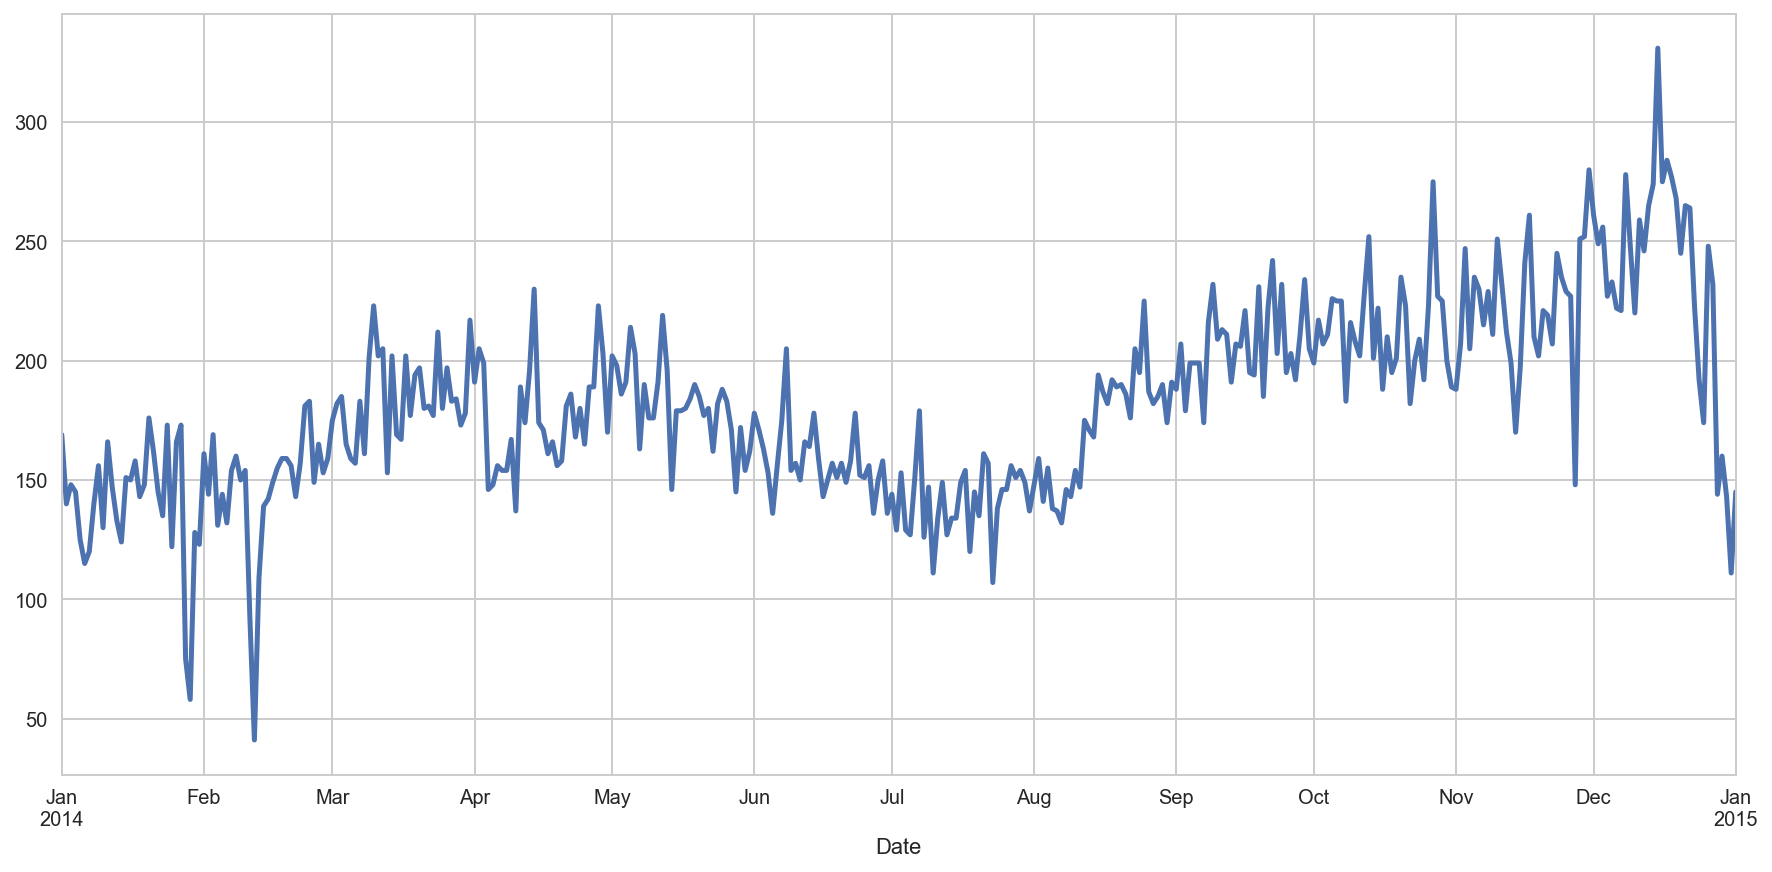

In [17]:
# Plotting Hospital Emergency Department visits
df_time_index['Hospital'].plot(lw=2.5, figsize=(15,7))  

In [18]:
# Printing Autocorrelation Function Array
print(acf(df.Hospital, nlags=50))

[ 1.          0.79151156  0.71596636  0.68901884  0.65349369  0.65928984
  0.66735137  0.68473499  0.63806278  0.57374884  0.56952065  0.54168106
  0.55829563  0.59058353  0.60906733  0.56236684  0.48619194  0.46507598
  0.46869199  0.46985483  0.47642619  0.51267672  0.46841917  0.43806205
  0.41352268  0.38613465  0.37758212  0.40335245  0.40952243  0.35890982
  0.32062573  0.30751783  0.30598014  0.32551578  0.34346343  0.36323009
  0.31371726  0.28503628  0.26941368  0.26636886  0.25933738  0.25463155
  0.26209468  0.23084336  0.19066871  0.1966941   0.18944328  0.19130533
  0.19939967  0.21165503  0.1690537 ]


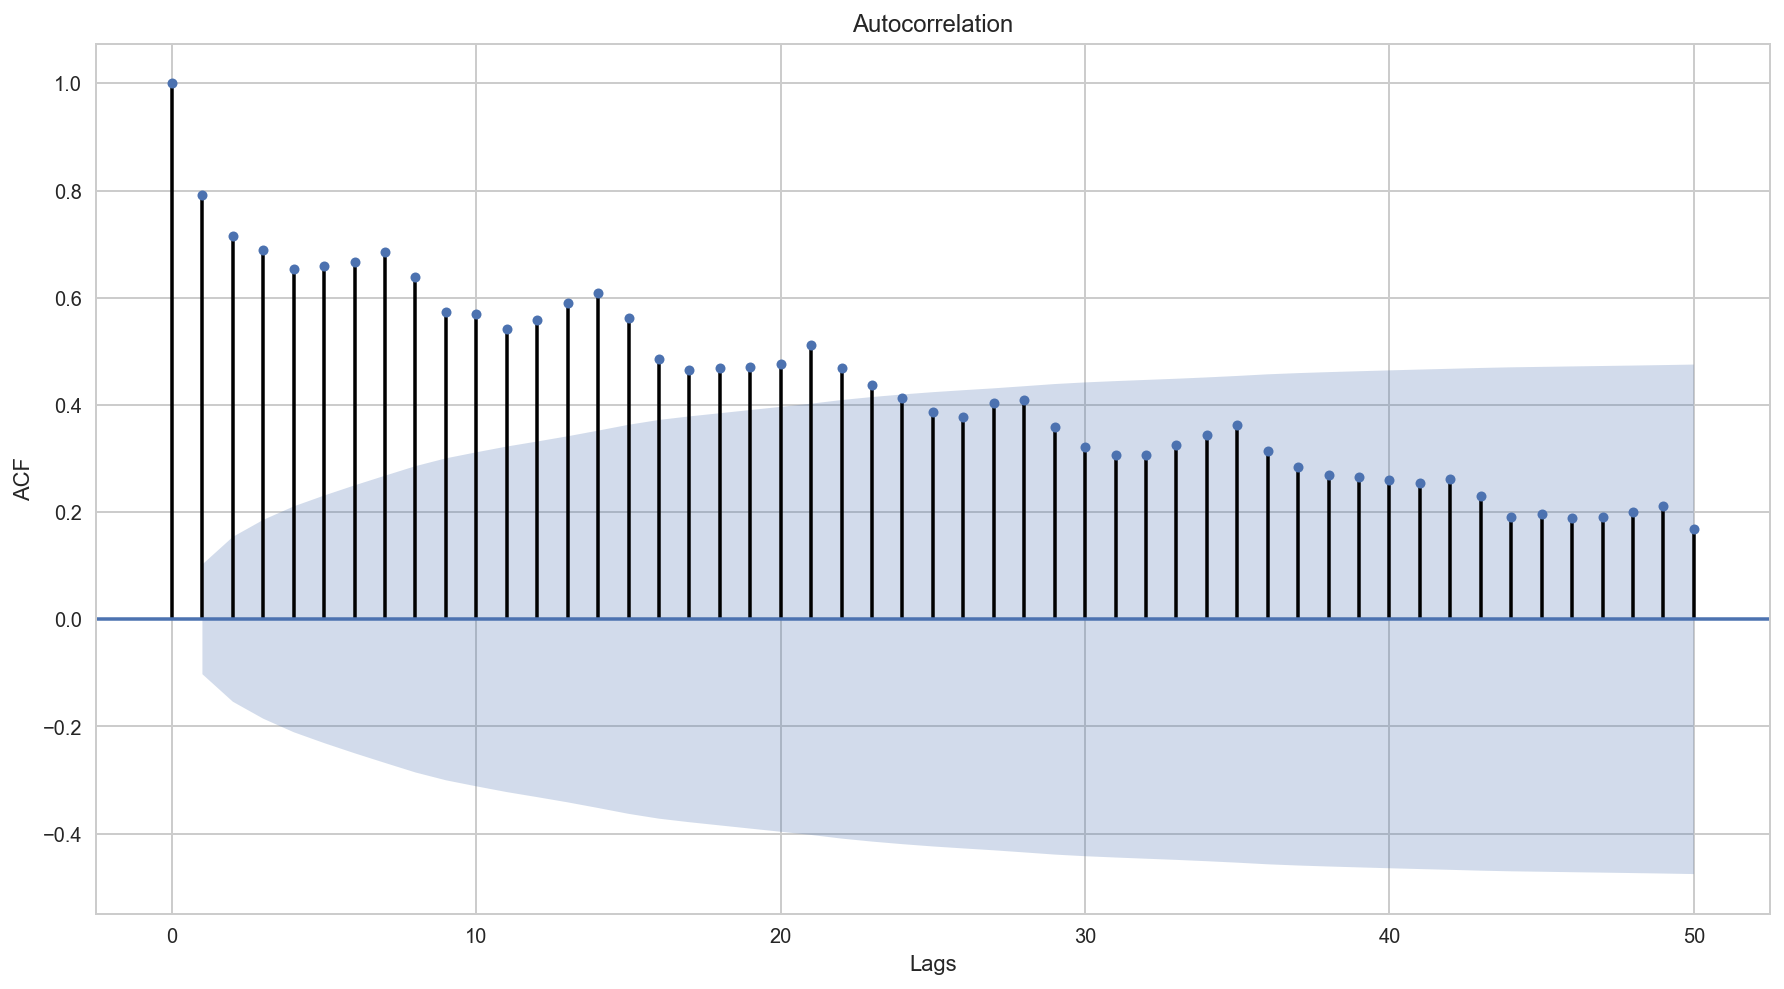

In [163]:
# Plotting Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(15,8))
plot_acf(df.Hospital, lags=50, ax=ax);
plt.xlabel('Lags')
plt.ylabel('ACF')

In [20]:
# Printing Partial Autocorrelation Function Array
print(pacf(df.Hospital, nlags=50))

[ 1.          0.79368009  0.24312075  0.19900941  0.08997958  0.1757297
  0.14999245  0.17658222 -0.04775773 -0.11599389  0.04490445 -0.03047896
  0.09718888  0.12586846  0.12895727 -0.07540529 -0.16590333 -0.05060476
  0.04671075  0.01975494 -0.02171388  0.15150728 -0.046507    0.04348355
 -0.04833479 -0.08721096 -0.08213112  0.04929681  0.00470352 -0.08404756
  0.00970245  0.00157658  0.06253482  0.05924073  0.04572794  0.05149833
 -0.12142786 -0.01373809 -0.01864217  0.05972307 -0.06284081 -0.06333478
 -0.02365505  0.02476261 -0.02884993  0.02022308 -0.0192766  -0.01758407
  0.00442649  0.06093159 -0.05709544]


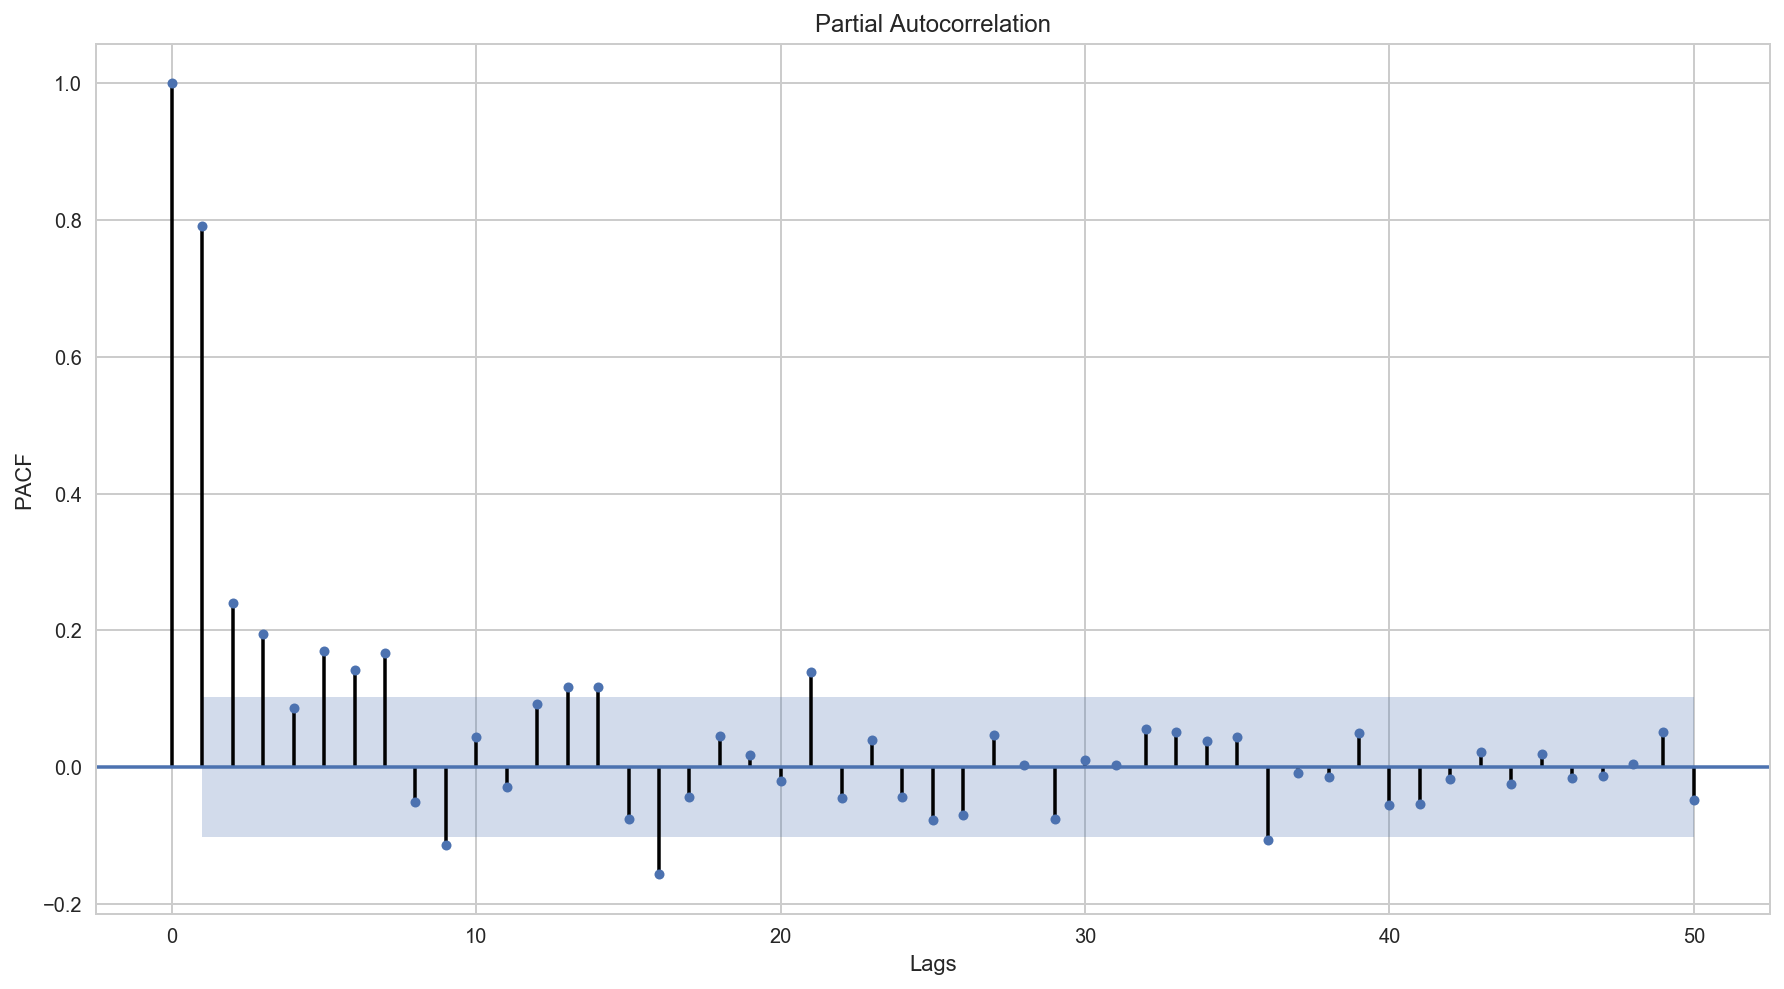

In [161]:
# Plotting Partial Autocorrelation Function (ACF)
fig, ax = plt.subplots(figsize=(15,8))
plot_pacf(df.Hospital, lags=50, ax=ax);
plt.xlabel('Lags')
plt.ylabel('PACF')

In [162]:
#ax = plt.figure()

In [116]:
#Performing a Seasonal decomposition of "The Hospital" dataset and 
#setting it equal to "result"
result = seasonal_decompose(df_time_index[['Hospital']].Hospital)

In [117]:
#Reviewing Seasonal result
result.seasonal

Date
2014-01-01    -7.963963
2014-01-02    -7.174047
2014-01-03    -2.653038
2014-01-04    -2.942523
2014-01-05     3.736048
2014-01-06    17.953081
2014-01-07    -0.955559
2014-01-08    -7.963963
2014-01-09    -7.174047
2014-01-10    -2.653038
2014-01-11    -2.942523
2014-01-12     3.736048
2014-01-13    17.953081
2014-01-14    -0.955559
2014-01-15    -7.963963
2014-01-16    -7.174047
2014-01-17    -2.653038
2014-01-18    -2.942523
2014-01-19     3.736048
2014-01-20    17.953081
2014-01-21    -0.955559
2014-01-22    -7.963963
2014-01-23    -7.174047
2014-01-24    -2.653038
2014-01-25    -2.942523
2014-01-26     3.736048
2014-01-27    17.953081
2014-01-28    -0.955559
2014-01-29    -7.963963
2014-01-30    -7.174047
                ...    
2014-12-03    -7.963963
2014-12-04    -7.174047
2014-12-05    -2.653038
2014-12-06    -2.942523
2014-12-07     3.736048
2014-12-08    17.953081
2014-12-09    -0.955559
2014-12-10    -7.963963
2014-12-11    -7.174047
2014-12-12    -2.653038
2014-12-13 

In [118]:
#Reviewing Trend result
result.trend

Date
2014-01-01           NaN
2014-01-02           NaN
2014-01-03           NaN
2014-01-04    137.428571
2014-01-05    133.285714
2014-01-06    135.571429
2014-01-07    133.000000
2014-01-08    136.000000
2014-01-09    139.142857
2014-01-10    141.714286
2014-01-11    142.285714
2014-01-12    143.857143
2014-01-13    143.000000
2014-01-14    147.000000
2014-01-15    143.714286
2014-01-16    143.857143
2014-01-17    150.000000
2014-01-18    155.428571
2014-01-19    154.571429
2014-01-20    152.428571
2014-01-21    154.571429
2014-01-22    151.571429
2014-01-23    154.142857
2014-01-24    153.714286
2014-01-25    141.285714
2014-01-26    128.857143
2014-01-27    127.857143
2014-01-28    120.714286
2014-01-29    126.285714
2014-01-30    123.142857
                 ...    
2014-12-03    246.857143
2014-12-04    238.428571
2014-12-05    240.857143
2014-12-06    240.714286
2014-12-07    235.571429
2014-12-08    240.142857
2014-12-09    242.000000
2014-12-10    248.142857
2014-12-11    255.71

In [119]:
#Reviewing Observed
result.observed

Date
2014-01-01    169
2014-01-02    140
2014-01-03    148
2014-01-04    145
2014-01-05    125
2014-01-06    115
2014-01-07    120
2014-01-08    140
2014-01-09    156
2014-01-10    130
2014-01-11    166
2014-01-12    147
2014-01-13    133
2014-01-14    124
2014-01-15    151
2014-01-16    150
2014-01-17    158
2014-01-18    143
2014-01-19    148
2014-01-20    176
2014-01-21    162
2014-01-22    145
2014-01-23    135
2014-01-24    173
2014-01-25    122
2014-01-26    166
2014-01-27    173
2014-01-28     75
2014-01-29     58
2014-01-30    128
             ... 
2014-12-03    256
2014-12-04    227
2014-12-05    233
2014-12-06    222
2014-12-07    221
2014-12-08    278
2014-12-09    248
2014-12-10    220
2014-12-11    259
2014-12-12    246
2014-12-13    265
2014-12-14    274
2014-12-15    331
2014-12-16    275
2014-12-17    284
2014-12-18    277
2014-12-19    268
2014-12-20    245
2014-12-21    265
2014-12-22    264
2014-12-23    223
2014-12-24    192
2014-12-25    174
2014-12-26    248
2014-

In [121]:
#Reviewing Residual result
result.resid

Date
2014-01-01          NaN
2014-01-02          NaN
2014-01-03          NaN
2014-01-04    10.513952
2014-01-05   -12.021763
2014-01-06   -38.524510
2014-01-07   -12.044441
2014-01-08    11.963963
2014-01-09    24.031189
2014-01-10    -9.061248
2014-01-11    26.656809
2014-01-12    -0.593191
2014-01-13   -27.953081
2014-01-14   -22.044441
2014-01-15    15.249677
2014-01-16    13.316904
2014-01-17    10.653038
2014-01-18    -9.486048
2014-01-19   -10.307477
2014-01-20     5.618347
2014-01-21     8.384131
2014-01-22     1.392534
2014-01-23   -11.968811
2014-01-24    21.938752
2014-01-25   -16.343191
2014-01-26    33.406809
2014-01-27    27.189776
2014-01-28   -44.758727
2014-01-29   -60.321752
2014-01-30    12.031189
                ...    
2014-12-03    17.106820
2014-12-04    -4.254525
2014-12-05    -5.204105
2014-12-06   -15.771763
2014-12-07   -18.307477
2014-12-08    19.904062
2014-12-09     6.955559
2014-12-10   -20.178895
2014-12-11    10.459761
2014-12-12   -14.632676
2014-12-13 

In [483]:
result.resid.to_csv('residual.csv', index=False)

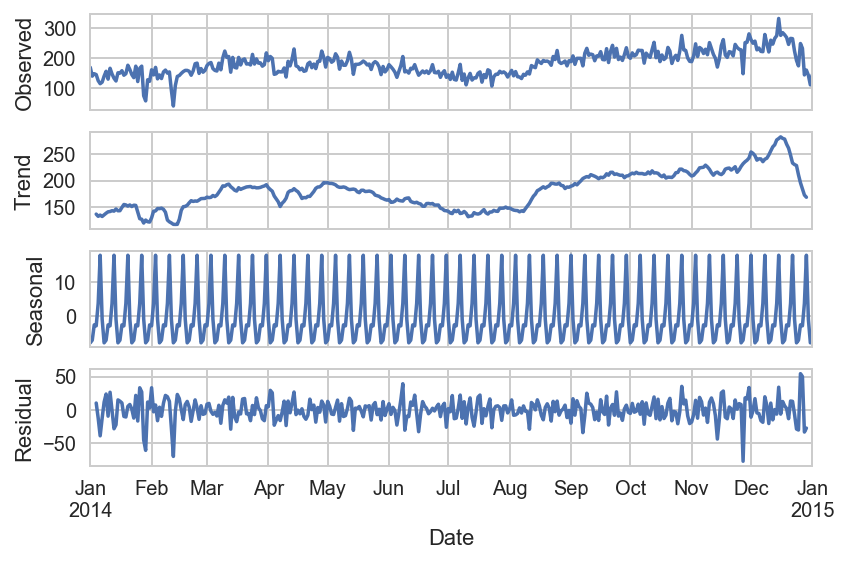

In [122]:
# Plotting the result of the decomposition of "The Hospital" dataset
ax = result.plot();

In [127]:
# Adjusting the width & height of the decomposition plot
ax.set_figwidth(15)
ax.set_figheight(10)

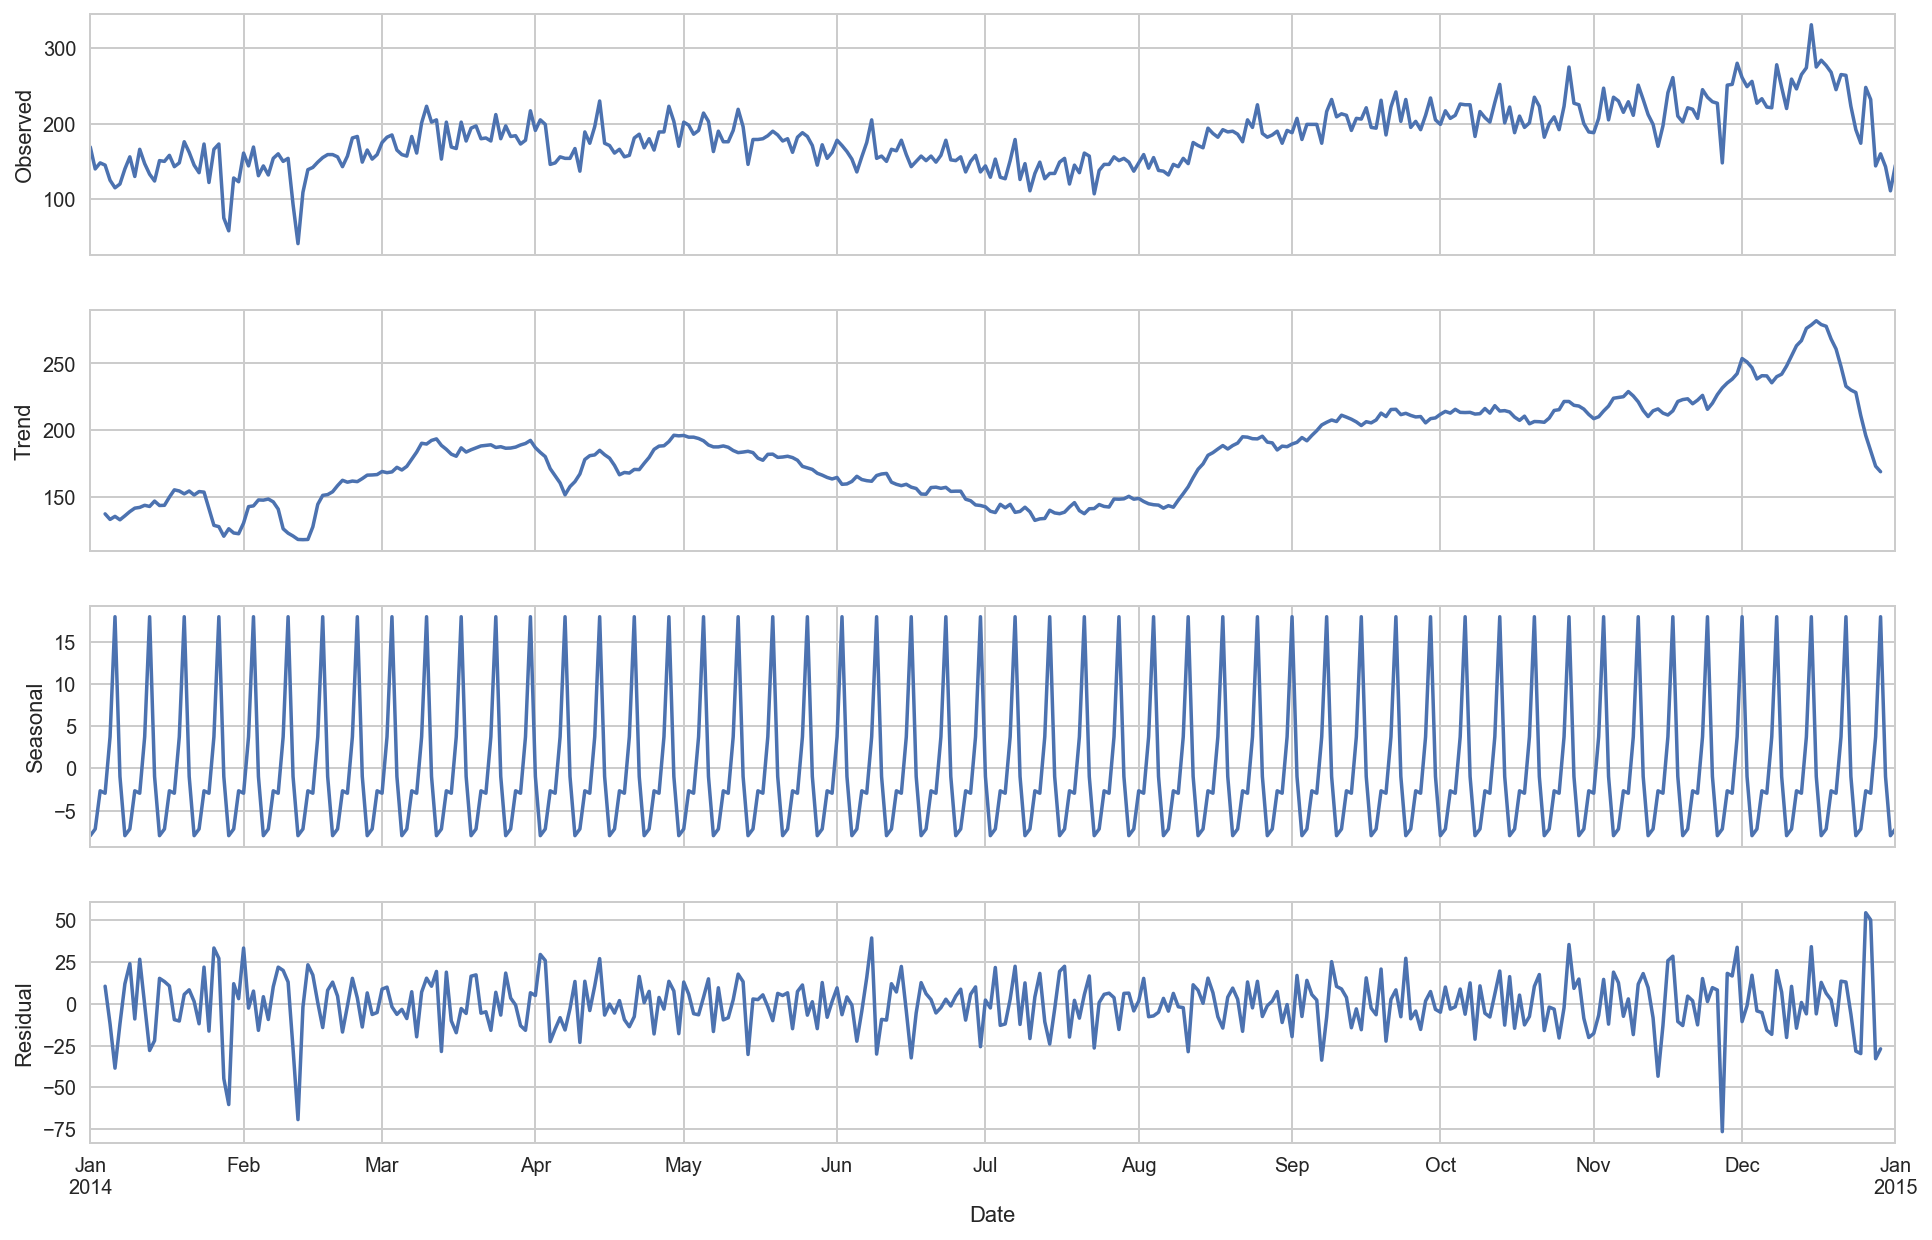

In [128]:
# Print the new charts w/ (width & height) enhancements
ax

In [129]:
# Reviewing "The Residual" of the "The Hospital" decompositon....I see there are Nulls present
result.resid

Date
2014-01-01          NaN
2014-01-02          NaN
2014-01-03          NaN
2014-01-04    10.513952
2014-01-05   -12.021763
2014-01-06   -38.524510
2014-01-07   -12.044441
2014-01-08    11.963963
2014-01-09    24.031189
2014-01-10    -9.061248
2014-01-11    26.656809
2014-01-12    -0.593191
2014-01-13   -27.953081
2014-01-14   -22.044441
2014-01-15    15.249677
2014-01-16    13.316904
2014-01-17    10.653038
2014-01-18    -9.486048
2014-01-19   -10.307477
2014-01-20     5.618347
2014-01-21     8.384131
2014-01-22     1.392534
2014-01-23   -11.968811
2014-01-24    21.938752
2014-01-25   -16.343191
2014-01-26    33.406809
2014-01-27    27.189776
2014-01-28   -44.758727
2014-01-29   -60.321752
2014-01-30    12.031189
                ...    
2014-12-03    17.106820
2014-12-04    -4.254525
2014-12-05    -5.204105
2014-12-06   -15.771763
2014-12-07   -18.307477
2014-12-08    19.904062
2014-12-09     6.955559
2014-12-10   -20.178895
2014-12-11    10.459761
2014-12-12   -14.632676
2014-12-13 

In [130]:
#Checking for Nulls in "The Residual".....There are 6 nulls...three at the beginning & three at the end.
result.resid.isnull().sum()

6

In [34]:
#Dropping Nulls at beginning & end of "result_B" series
result_B = result.resid
result_B = result_B.dropna(axis=0, how='all')

In [131]:
#Print out reslut of "result_B" series
result_B

Date
2014-01-04    10.513952
2014-01-05   -12.021763
2014-01-06   -38.524510
2014-01-07   -12.044441
2014-01-08    11.963963
2014-01-09    24.031189
2014-01-10    -9.061248
2014-01-11    26.656809
2014-01-12    -0.593191
2014-01-13   -27.953081
2014-01-14   -22.044441
2014-01-15    15.249677
2014-01-16    13.316904
2014-01-17    10.653038
2014-01-18    -9.486048
2014-01-19   -10.307477
2014-01-20     5.618347
2014-01-21     8.384131
2014-01-22     1.392534
2014-01-23   -11.968811
2014-01-24    21.938752
2014-01-25   -16.343191
2014-01-26    33.406809
2014-01-27    27.189776
2014-01-28   -44.758727
2014-01-29   -60.321752
2014-01-30    12.031189
2014-01-31     3.081610
2014-02-01    33.371095
2014-02-02    -2.593191
                ...    
2014-11-30    33.835380
2014-12-01   -10.667367
2014-12-02    -1.187298
2014-12-03    17.106820
2014-12-04    -4.254525
2014-12-05    -5.204105
2014-12-06   -15.771763
2014-12-07   -18.307477
2014-12-08    19.904062
2014-12-09     6.955559
2014-12-10 

In [132]:
#Perfom Augmented Dickey Fuller (ADF) test to confirm Stationarity

df_test = adfuller(result_B.values)
p_value = df_test[1]
print(p_value)

8.63517601566e-18


In [133]:
#Compare the ADF when "Stationarity does not exist"...ie, Moving Average &
#Variance is not constant.....to the the p-value above.

df_test = adfuller(df['Hospital'])
p_value = df_test[1]
print(p_value)

0.154745865707


In [493]:
#The ADF tests the null hypothesis that Demand follows a unit 
#root process. You usually reject the null when the p-value is 
#less than or equal to a specified significance level, often 0.05 


# Models

In [134]:
#Autoregressive Model (Moving Average was set to zero)
ar1 = ARMA(result_B.values, (10, 0)).fit()

In [135]:
#Print the summary for Autoregressive Model
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                    ARMA(10, 0)   Log Likelihood               -1448.840
Method:                       css-mle   S.D. of innovations             13.513
Date:                Sun, 17 Dec 2017   AIC                           2921.681
Time:                        21:36:24   BIC                           2968.314
Sample:                             0   HQIC                          2940.223
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0611      0.176      0.346      0.729      -0.285       0.407
ar.L1.y       -0.3044      0.053     -5.777      0.000      -0.408      -0.201
ar.L2.y       -0.5118      0.055     -9.323      0.000      -0.619      -0.404
ar.L3.y       -0.6038      0.062     -9.799      0.000      -0.725      -0.483
ar.L4.y       -0.4730      0.069     -6.886      0.000      -0.608      -0.338
ar.L5.y       -0.3503      0.071     -4.927      0.000      -0.490      -0.211
ar.L6.y       -0.3353      0.071     -4.714      0.000      -0.475      -0.196
ar.L7.y       -0.2441      0.069     -3.542      0.000      -0.379      -0.109
ar.L8.y       -0.0971      0.063     -1.551      0.122      -0.220       0.026
ar.L9.y       -0.1208      0.057     -2.106      0.036      -0.233      -0.008
ar.L10.y      -0.0320      0.055     -0.581      0.562      -0.140       0.076
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             0.9110           -0.7870j            1.2038           -0.1134
AR.2             0.9110           +0.7870j            1.2038            0.1134
AR.3             0.5536           -1.1487j            1.2751           -0.1785
AR.4             0.5536           +1.1487j            1.2751            0.1785
AR.5            -0.0455           -1.3237j            1.3245           -0.2555
AR.6            -0.0455           +1.3237j            1.3245            0.2555
AR.7            -0.9672           -0.8654j            1.2978           -0.3838
AR.8            -0.9672           +0.8654j            1.2978            0.3838
AR.9            -1.3478           -0.0000j            1.3478           -0.5000
AR.10           -3.3292           -0.0000j            3.3292           -0.5000
------------------------------------------------------------------------------
"""

In [136]:
# Developing Predictions for Autoregressive Model
params = ar1.params
residuals = ar1.resid
p = ar1.k_ar
q = ar1.k_ma
k_exog = ar1.k_exog
k_trend = ar1.k_trend
steps = 180

oos_predictions = _arma_predict_out_of_sample(params, steps, residuals, 
                                p, q, k_trend, k_exog, 
                                endog=result_B.values, exog=None, start=100)

print(oos_predictions)

[ 5.30018022 -3.45674758 -3.76024608 -3.01177934 -2.29275283  2.99262119
  0.43403969  1.59603069  0.30170645 -0.25321976  0.07113847 -0.31899178
 -0.40864408 -0.05086997 -0.09988319  0.38600887  0.32015212  0.20798451
  0.08253827 -0.07638056 -0.06058403  0.00541077  0.03972385  0.10604935
  0.0953704   0.09441471  0.08210551  0.05758692  0.04780498  0.04110936
  0.04469823  0.0590775   0.06641127  0.07173266  0.0692426   0.06332166
  0.05941543  0.05697084  0.05740718  0.05936689  0.06091717  0.06243398
  0.06276498  0.06235072  0.06159634  0.06071266  0.06030967  0.06036828
  0.06070975  0.06116224  0.06140364  0.06143801  0.06131227  0.06112245
  0.06099234  0.06094038  0.0609661   0.06103974  0.06110833  0.06115175
  0.0611553   0.06112844  0.06109399  0.06106738  0.06105941  0.06106782
  0.06108294  0.06109679  0.06110317  0.06110195  0.06109624  0.06108963
  0.0610854   0.06108452  0.06108632  0.06108931  0.06109176  0.06109281
  0.06109242  0.06109117  0.06108992  0.06108919  0

In [137]:
len(oos_predictions)

180

In [138]:
result_B

Date
2014-01-04    10.513952
2014-01-05   -12.021763
2014-01-06   -38.524510
2014-01-07   -12.044441
2014-01-08    11.963963
2014-01-09    24.031189
2014-01-10    -9.061248
2014-01-11    26.656809
2014-01-12    -0.593191
2014-01-13   -27.953081
2014-01-14   -22.044441
2014-01-15    15.249677
2014-01-16    13.316904
2014-01-17    10.653038
2014-01-18    -9.486048
2014-01-19   -10.307477
2014-01-20     5.618347
2014-01-21     8.384131
2014-01-22     1.392534
2014-01-23   -11.968811
2014-01-24    21.938752
2014-01-25   -16.343191
2014-01-26    33.406809
2014-01-27    27.189776
2014-01-28   -44.758727
2014-01-29   -60.321752
2014-01-30    12.031189
2014-01-31     3.081610
2014-02-01    33.371095
2014-02-02    -2.593191
                ...    
2014-11-30    33.835380
2014-12-01   -10.667367
2014-12-02    -1.187298
2014-12-03    17.106820
2014-12-04    -4.254525
2014-12-05    -5.204105
2014-12-06   -15.771763
2014-12-07   -18.307477
2014-12-08    19.904062
2014-12-09     6.955559
2014-12-10 

In [58]:
df_amended = df.drop(df.index[[0,1,2, -1, -2, -3]])

In [140]:
len(df_amended)

360

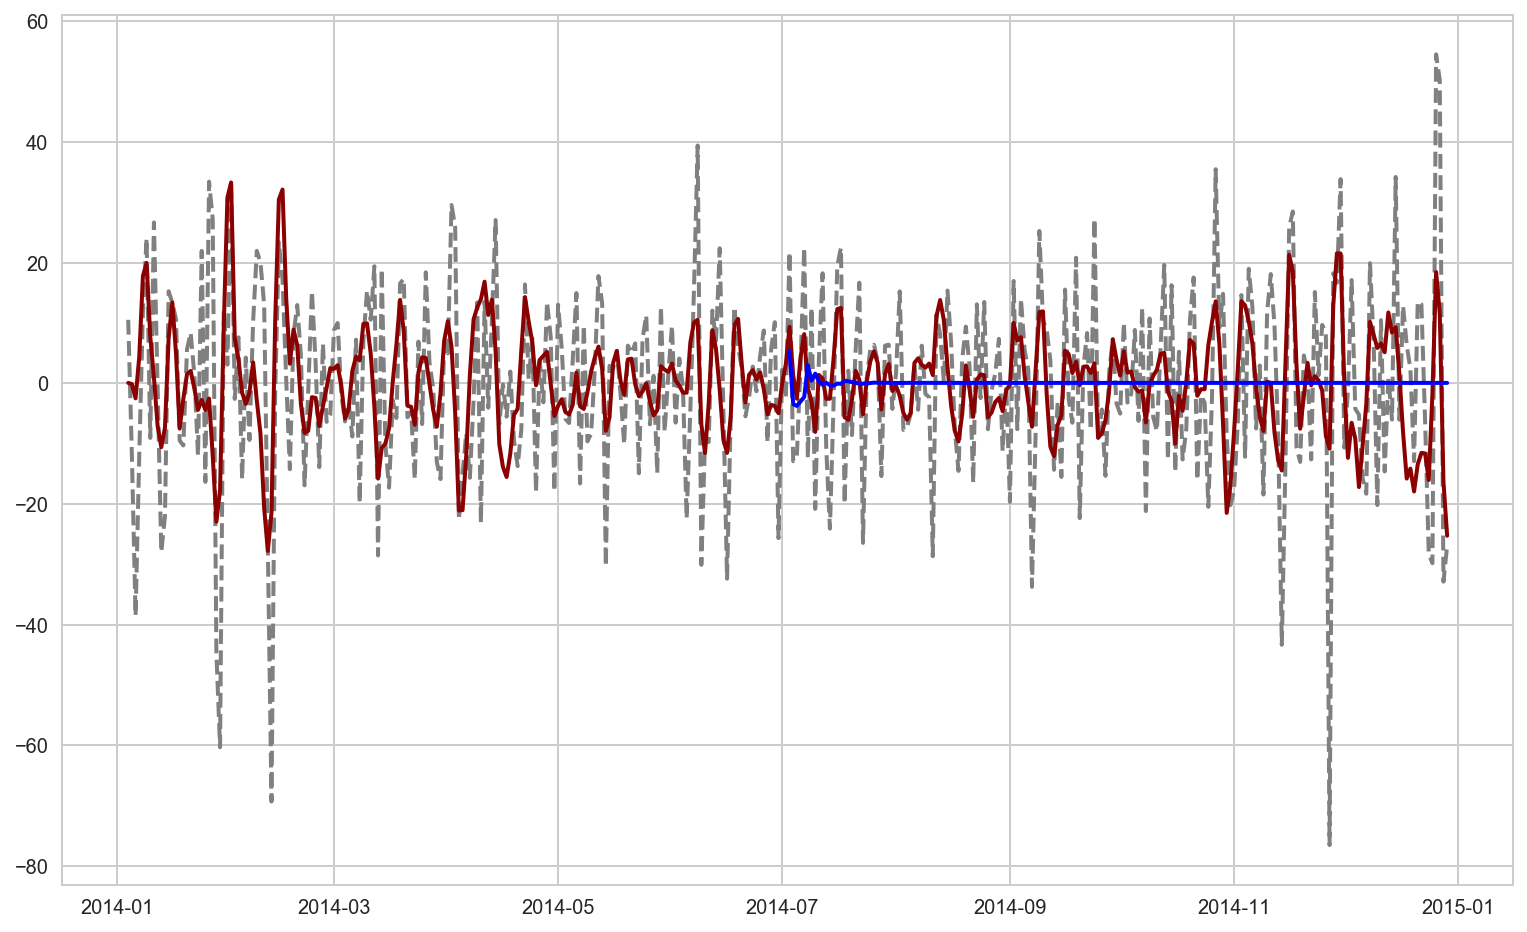

In [141]:
#Plotting ARMA Model w/ Predictions
date_ticks = df_amended         

fig, ax = plt.subplots(figsize=(13,8))
ax.plot(date_ticks['Date'], result_B, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks['Date'], ar1.fittedvalues, lw=2, color='darkred')
ax.plot(date_ticks.loc[183:, 'Date'], oos_predictions, lw=2, color='blue')
plt.show()

In [142]:
# R2 Score for my Model

r2_score(result_B, ar1.fittedvalues)

0.29175603827046281

In [143]:
# Moving Average Model (Autoregressive set to zero)
ma1 = ARMA(result_B.values, (0,3)).fit()

In [144]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                     ARMA(0, 3)   Log Likelihood               -1443.113
Method:                       css-mle   S.D. of innovations             13.233
Date:                Sun, 17 Dec 2017   AIC                           2896.226
Time:                        21:38:25   BIC                           2915.657
Sample:                             0   HQIC                          2903.952
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.013      0.545      0.586      -0.018       0.031
ma.L1.y       -0.3556      0.052     -6.808      0.000      -0.458      -0.253
ma.L2.y       -0.4090      0.054     -7.579      0.000      -0.515      -0.303
ma.L3.y       -0.2353      0.061     -3.832      0.000      -0.356      -0.115
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.3689           -1.5411j            2.0613           -0.3656
MA.3           -1.3689           +1.5411j            2.0613            0.3656
-----------------------------------------------------------------------------
"""

In [145]:
# Developing Predictions for Moving Averages (MA)
params = ma1.params
residuals = ma1.resid
p = ma1.k_ar
q = ma1.k_ma
k_exog = ma1.k_exog
k_trend = ma1.k_trend
steps = 180

oos_predictions_ma = _arma_predict_out_of_sample(params, steps, residuals, 
                                p, q, k_trend, k_exog, 
                                endog=result_B.values, exog=None, start=100)

print(oos_predictions_ma)

[ 3.66693356  2.36964445 -0.34899864  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309  0.00681309
  0.00681309  0.00681309  0.00681309  0.00681309  0

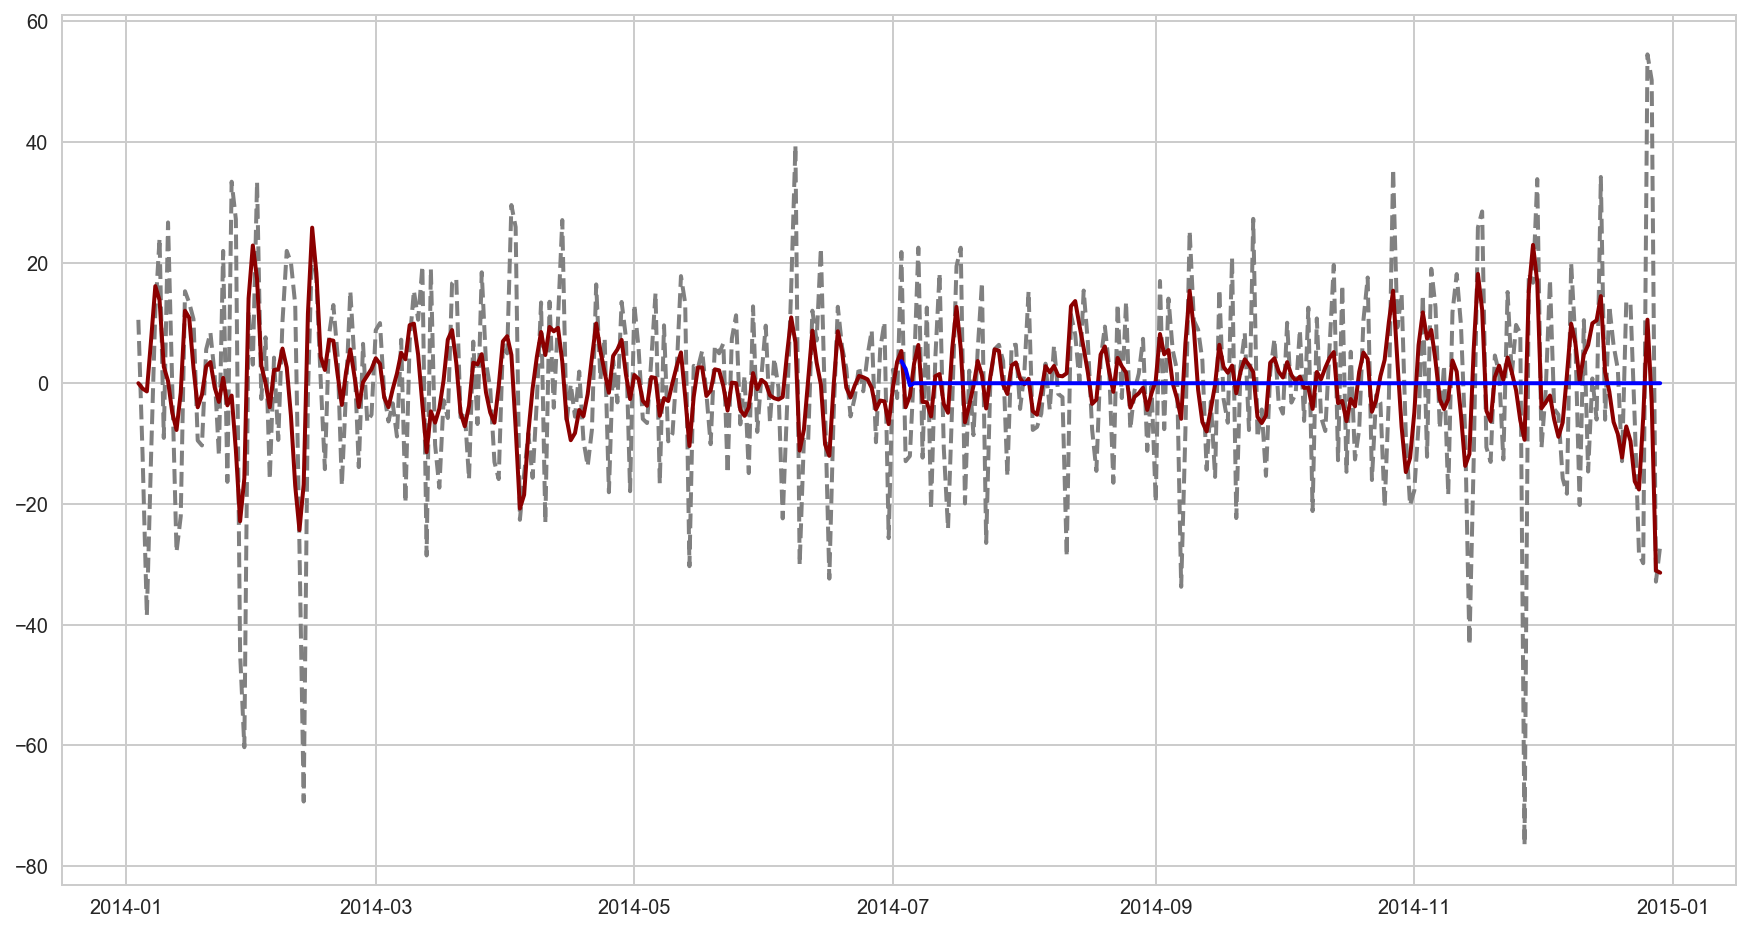

In [146]:
#Plotting ARMA Model w/ Predictions
date_ticks = df_amended                   

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(date_ticks['Date'], result_B, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks['Date'], ma1.fittedvalues, lw=2, color='darkred')
ax.plot(date_ticks.loc[183:, 'Date'], oos_predictions_ma, lw=2, color='blue')
plt.show()

In [147]:
# R2 Score for my Model

r2_score(result_B, ma1.fittedvalues)

0.31249398263266248

In [151]:
#Autoregressive Integrated with Moving Average
ar1ma1 = ARMA(result_B.values, (4,1)).fit()

In [152]:
ar1ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                     ARMA(4, 1)   Log Likelihood               -1432.862
Method:                       css-mle   S.D. of innovations             12.844
Date:                Sun, 17 Dec 2017   AIC                           2879.725
Time:                        21:39:56   BIC                           2906.927
Sample:                             0   HQIC                          2890.541
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.791      0.430      -0.009       0.022
ar.L1.y        0.5785      0.053     10.949      0.000       0.475       0.682
ar.L2.y       -0.2509      0.060     -4.165      0.000      -0.369      -0.133
ar.L3.y       -0.1643      0.062     -2.663      0.008      -0.285      -0.043
ar.L4.y        0.0256      0.055      0.465      0.642      -0.082       0.134
ma.L1.y       -1.0000      0.009   -112.515      0.000      -1.017      -0.983
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8185           -1.1494j            1.4110           -0.1515
AR.2            0.8185           +1.1494j            1.4110            0.1515
AR.3           -2.6423           -0.0000j            2.6423           -0.5000
AR.4            7.4184           -0.0000j            7.4184           -0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [153]:
# Developing Predictions for ARIMA
params = ar1ma1.params
residuals = ar1ma1.resid
p = ar1ma1.k_ar
q = ar1ma1.k_ma
k_exog = ar1ma1.k_exog
k_trend = ar1ma1.k_trend
steps = 180

oos_predictions_arima = _arma_predict_out_of_sample(params, steps, residuals, 
                                p, q, k_trend, k_exog, 
                                endog=result_B.values, exog=None, start=100)

print(oos_predictions_arima)

[  7.70652935e+00   2.79390319e+00  -2.17296585e+00  -2.94535967e+00
  -1.41531943e+00   3.53953022e-01   9.93329724e-01   6.48125587e-01
   3.64680045e-02  -2.90521920e-01  -2.53130740e-01  -5.77947615e-02
   8.38933698e-02   1.02334661e-01   4.63150518e-02  -8.99889289e-03
  -2.63452073e-02  -1.28250579e-02   7.00292901e-03   1.65152108e-02
   1.43776195e-02   7.84260518e-03   3.54310448e-03   3.29024421e-03
   5.24174957e-03   6.97327616e-03   7.41680107e-03   6.91181456e-03
   6.27385582e-03   6.00295366e-03   6.10063027e-03   6.31699960e-03
   6.44584078e-03   6.44310333e-03   6.37614258e-03   6.32246233e-03
   6.31195720e-03   6.33028059e-03   6.35062225e-03   6.35814430e-03
   6.35411242e-03   6.34701948e-03   6.34321266e-03   6.34364509e-03
   6.34591261e-03   6.34755976e-03   6.34777521e-03   6.34712507e-03
   6.34648232e-03   6.34628038e-03   6.34643716e-03   6.34666749e-03
   6.34677813e-03   6.34675341e-03   6.34667752e-03   6.34662753e-03
   6.34662456e-03   6.34664721e-03

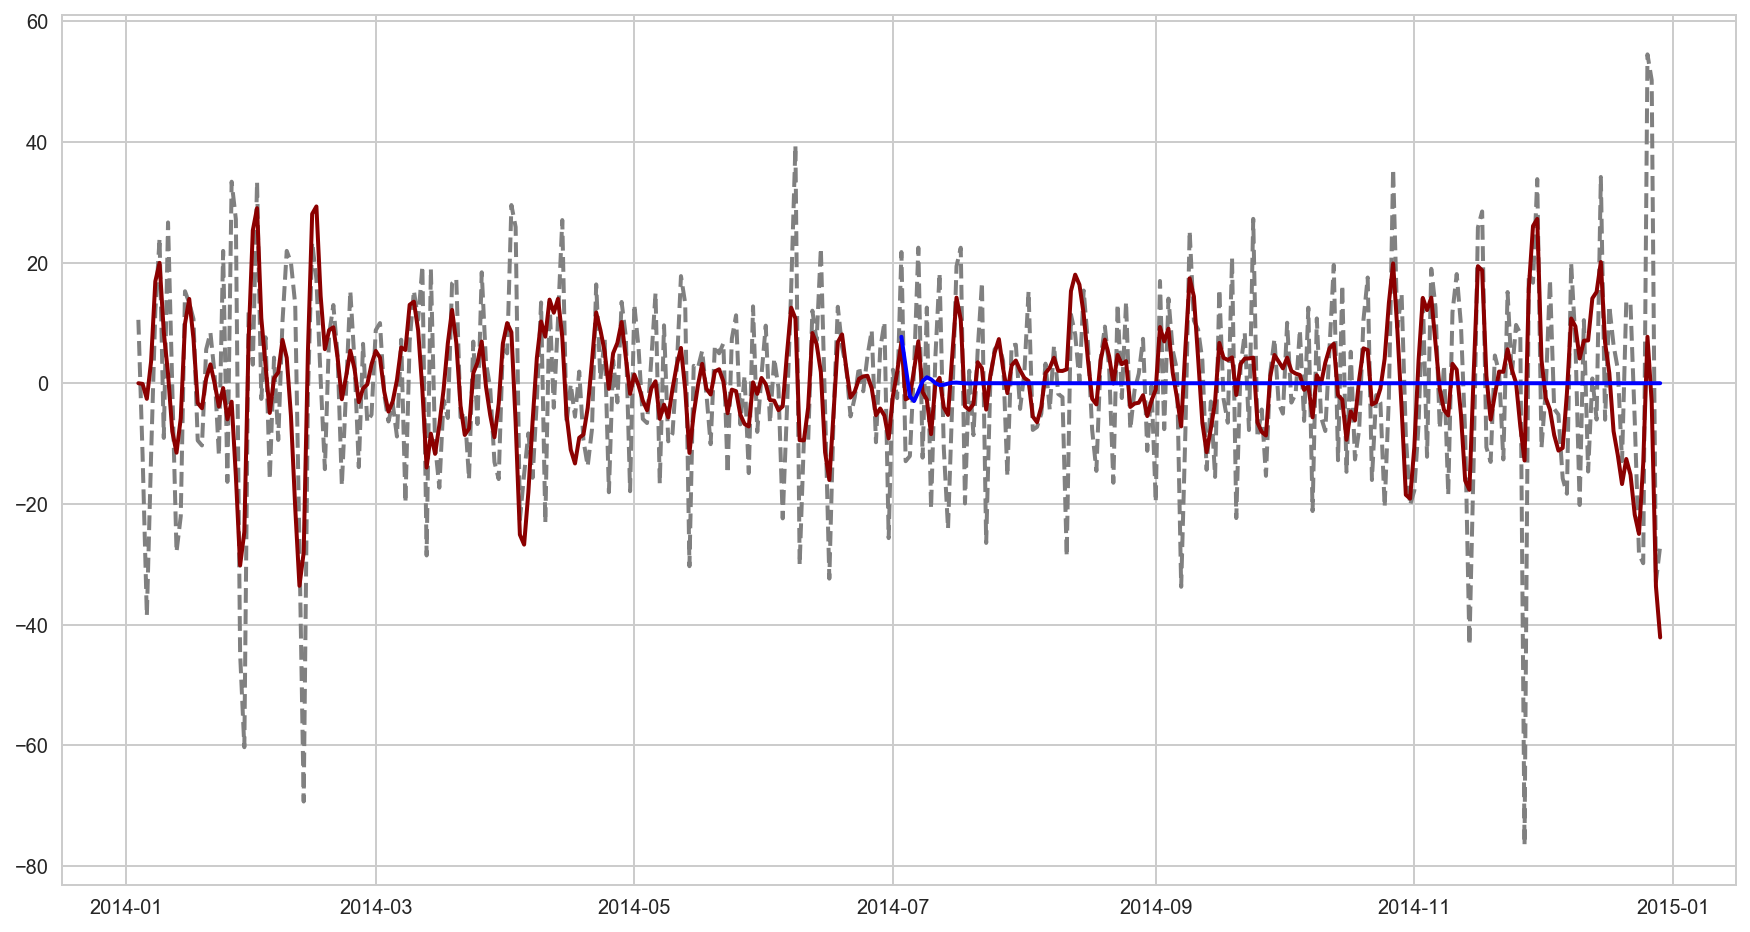

In [154]:
#Plotting ARIMA Model w/ Predictions
date_ticks = df_amended                   

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(date_ticks['Date'], result_B, lw=2, color='grey', ls='dashed')
ax.plot(date_ticks['Date'], ar1ma1.fittedvalues, lw=2, color='darkred')
ax.plot(date_ticks.loc[183:, 'Date'], oos_predictions_arima, lw=2, color='blue')
plt.show()

In [155]:
# R2 Score for my Model

r2_score(result_B, ar1ma1.fittedvalues)

0.34971304860324504